<a href="https://colab.research.google.com/github/ydeng-MLM/ECE687_Kaggle_Airbnb_Recommendation/blob/main/Summary_Airbnb_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch was used for DNN built, but not enough optimization time 
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch import nn

#Results analysis library
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

#Data preparation import
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#ML algorithms import
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time

**Data preparation**

In [ ]:
#Reading the data from train.csv
df = pd.read_csv('train.csv')

In [ ]:
#Checking the columns
df.columns

Index(['id', 'Decision', 'Host_response_time', 'Host_is_superhost',
       'Host_has_profile_pic', 'Host_identity_verified', 'Neighbourhood',
       'Property_type', 'Room_type', 'Accommodates', 'Bathrooms_text',
       'Bedrooms', 'Beds', 'Essentials', 'Cooking', 'Balcony', 'Parking',
       'Price', 'Number_of_reviews', 'Review_scores_rating',
       'Instant_bookable', 'Month'],
      dtype='object')

In [ ]:
#Print out all the NaN entry
df.columns[df.isnull().any()].tolist()

['Host_response_time',
 'Host_is_superhost',
 'Host_has_profile_pic',
 'Host_identity_verified',
 'Bedrooms',
 'Beds',
 'Review_scores_rating']

In [ ]:
#Cleaning all the NaN entry
df['Host_response_time'].fillna("No response", inplace = True)
df['Host_is_superhost'].fillna("t", inplace = True)
df['Host_has_profile_pic'].fillna("t", inplace = True)
df['Host_identity_verified'].fillna("t", inplace = True)
df['Bedrooms'].fillna(1, inplace = True)
df['Beds'].fillna(1, inplace = True)
review_mean = df['Review_scores_rating'].mean()
df['Review_scores_rating'].fillna(review_mean, inplace = True)

df['Price'] = df['Price'].str.replace(',', '')
df['Price'] = df['Price'].str.replace('$', '')
df['Price'] = df['Price'].astype(float)


In [ ]:
#Use column transformer to define specific encoders for each column in the dataframe
column_trans = make_column_transformer((OneHotEncoder(drop='if_binary'),
                                        ['Host_is_superhost', 'Host_has_profile_pic', 'Host_identity_verified',
                                         'Instant_bookable']),
                                      (OrdinalEncoder(), ['Host_response_time', 'Neighbourhood', 'Property_type',
                                                          'Room_type', 'Bathrooms_text', 'Essentials', 
                                                          'Month']),
                                      remainder='passthrough')

In [ ]:
#Defining the label from the dataframe
labels = df.to_numpy()[:, 1].astype('float32')

#Encoder is defined here wth the column transformer
enc = column_trans.fit(df.drop(columns=['id', 'Decision']))
#Features now is encoded by the encoder
features = enc.transform(df.drop(columns=['id', 'Decision']))

#Defining the scaler and fit on the dataset
scaler = StandardScaler()
#scaler = RobustScaler()
scaler.fit(features)
#The features are now standarized by the standard scaler
features = scaler.transform(features)

**Train/Test set Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)

print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (6723, 20) (6723,)
Test (748, 20) (748,)


**Summary of all model cross validation/test set performance**

In [ ]:
rf = RandomForestClassifier(n_estimators=1300, max_depth=30, max_features='sqrt', min_samples_split=3)
rf_cv = cross_val_score(rf, X_train, y_train, cv=10, scoring='accuracy')

SVM = svm.SVC(kernel='rbf', C=10, gamma=0.1)
SVM_cv = cross_val_score(SVM, X_train, y_train, cv=10, scoring='accuracy')

LR = LogisticRegression(solver='newton-cg', C=0.2)
LR_cv = cross_val_score(LR, X_train, y_train, cv=10, scoring='accuracy')

kNN = KNeighborsClassifier(n_neighbors=1)
kNN_cv = cross_val_score(kNN, X_train, y_train, cv=10, scoring='accuracy')

In [ ]:
rf.fit(X_train, y_train)
SVM.fit(X_train, y_train)
LR.fit(X_train, y_train)
kNN.fit(X_train, y_train)

#Report final performance on test set
y_pred_rf = rf.predict(X_test)
y_pred_SVM = SVM.predict(X_test)
y_pred_LR = LR.predict(X_test)
y_pred_kNN = kNN.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_SVM))
print(classification_report(y_test, y_pred_LR))
print(classification_report(y_test, y_pred_kNN))

              precision    recall  f1-score   support

         0.0       0.78      0.68      0.73       256
         1.0       0.85      0.90      0.87       492

    accuracy                           0.83       748
   macro avg       0.82      0.79      0.80       748
weighted avg       0.82      0.83      0.82       748

              precision    recall  f1-score   support

         0.0       0.68      0.58      0.63       256
         1.0       0.80      0.86      0.83       492

    accuracy                           0.76       748
   macro avg       0.74      0.72      0.73       748
weighted avg       0.76      0.76      0.76       748

              precision    recall  f1-score   support

         0.0       0.65      0.39      0.48       256
         1.0       0.74      0.89      0.81       492

    accuracy                           0.72       748
   macro avg       0.69      0.64      0.64       748
weighted avg       0.71      0.72      0.70       748

              preci

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.wa

<Figure size 432x288 with 0 Axes>

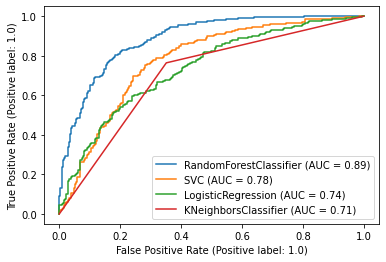

In [ ]:
from sklearn.metrics import plot_roc_curve


plt.figure()
rf_disp = plot_roc_curve(rf, X_test, y_test)
plot_roc_curve(SVM, X_test, y_test, ax=rf_disp.ax_)
plot_roc_curve(LR, X_test, y_test, ax=rf_disp.ax_)
plot_roc_curve(kNN, X_test, y_test, ax=rf_disp.ax_)
